# Fetch data

In [1]:
import pld
from pathlib import Path
import ipywidgets as ipw
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [19]:
DATASET = "20250127_170419"
DATAPATH = (Path(".") / DATASET).absolute()

In [20]:
analyzer = pld.RHEEDAnalyzer()
analyzer.set_outdir(DATAPATH / "output")

In [21]:
analyzer.load_data(DATAPATH)

In [22]:
analyzer.crop_to_global_region_of_interest()

In [23]:
frame = pld.RHEEDFrame(7, analyzer.data[7])

/Users/pietromani/Documents/Starting/Coding/PLD/PLD-scripts/20250127_170419/output


In [24]:
frame.plot( show_peaks=True,
   show_regions_of_interest=True,
    figsize=(4, 3))



In [25]:
analyzer.generate_frames(
    sigma=1,
    params={
        "min_distance": 10,
        "threshold_rel": 0.1,
    }
)

# Extract time series

In [ ]:
# intensities = analyzer.get_peak_intensities(sigma=1)

In [ ]:
# import csv

# with open("central_peak_intensity_time_series.csv", "w") as f:
#     writer = csv.writer(f)
#     writer.writerow(["time", "intensity"])
#     for t, i in zip(analyzer.timestamps, intensities[0]):
#         writer.writerow([t, i])

## RHEED frame analysis

### Single frame check

In [28]:
def plot_frame(frame: pld.RHEEDFrame):
    clear_output(wait=True)
    frame.plot(
        show_peaks=True,
        show_regions_of_interest=True,
        figsize=(4, 3),
    )


plot_frame(analyzer.frames[0])

rheed_slider = ipw.IntSlider(min=0, max=len(analyzer.frames) - 1)


def on_slider_change(change):
    plot_frame(analyzer.frames[change["new"]])


rheed_slider.observe(on_slider_change, names="value")

In [29]:
rheed_slider

IntSlider(value=0, max=2686)

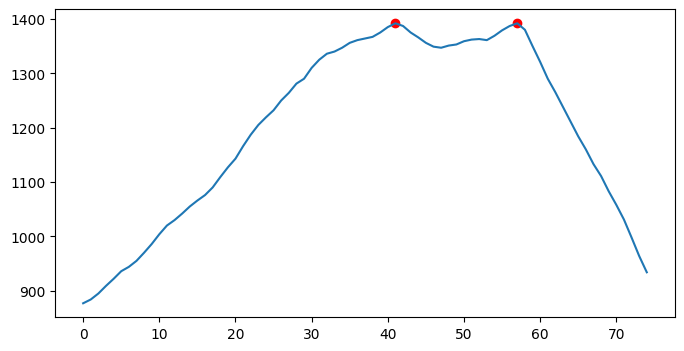

In [15]:
def plot_spectrum(frame: pld.RHEEDFrame):
    spectrum = frame.get_center_peak_cross_section()
    peaks, _ = find_peaks(spectrum, distance=20 // 2, prominence=25)

    clear_output(wait=True)
    plt.figure(figsize=(8, 4))
    plt.plot(spectrum, label="Vertical Intensity Profile")
    plt.scatter(peaks, spectrum[peaks], color="red", label="Detected Peaks")
    # plt.ylim(2, 10)
    plt.show()


plot_spectrum(analyzer.frames[0])

cross_section_slider = ipw.IntSlider(min=0, max=len(analyzer.frames) - 1)


def on_slider_change(change):
    plot_spectrum(analyzer.frames[change["new"]])


cross_section_slider.observe(on_slider_change, names="value")

In [16]:
cross_section_slider

IntSlider(value=0, max=2686)

In [18]:
import plotly.graph_objects as go

ratios = [frame.get_peak_ratio_sum(prominence=25) for frame in analyzer.frames]

fig = go.Figure()
fig.add_trace(go.Scatter(y=ratios, mode="markers"))
fig.update_layout(
    xaxis=dict(range=[0, len(ratios)]),
)

In [ ]:
# frame.plot_power_spectrum(figsize=(4, 3))

In [ ]:
# Plottare solo la ROI del picco centrale
frame = analyzer.frames[0]

# Estrai la ROI del picco centrale (indice 1)
top, bottom, left, right = frame.ROIs[1]  # 0=sinistra, 1=centro, 2=destra

# Estrai la regione dell'immagine
roi_data = frame.data[top:bottom, left:right]

# Visualizza (con transpose per allineare x e y correttamente)
import plotly.graph_objects as go

fig = go.Figure(
    data=go.Heatmap(
        z=roi_data,
        colorscale="Viridis",
    )
)
fig.update_layout(
    title="ROI Picco Centrale",
    xaxis_title="X (pixel)",
    yaxis_title="Y (pixel)",
    yaxis=dict(autorange="reversed"),  # Inverti Y per allineare con immagine
)
fig.show()

# Time series

In [19]:
analyzer.plot_sharpness_time_series(
    data=analyzer.get_sharpness(),
    figsize=(8, 4),
)

In [20]:
analyzer.plot_radial_profile_time_series(
    data=analyzer.get_radial_profile(),
    figsize=(8, 4),
)

In [21]:
import numpy as np

analyzer.plot_intensity_time_series(
    data=np.array(analyzer.get_peak_intensities()) / 255,
    figsize=(4, 4),
)

# Score

In [22]:
analyzer.compute_deposition_score()

np.float64(1.0)

In [ ]:
# analyzer.analyze_quality(0)

In [ ]:
assert False

# Optimization

In [ ]:
from bayes_opt import BayesianOptimization

from bayes_opt import acquisition

acq = acquisition.UpperConfidenceBound(kappa=2.5)


def evaluate_growth_quality(
    gas_pressure,
    lase_fluence,
    substrate_temperature,
    i=0,
):
    """
    Replace this with your actual function that evaluates growth quality.
    It could run an experiment or use a surrogate model.
    """
    # Placeholder: Assume we have a function that scores growth quality
    score = analyzer.analyze_quality(i)
    return score


pbounds = {
    "gas_pressure": (1e-6, 1e-2),  # Torr
    "lase_fluence": (0.1, 1.0),  # J/cm^2
    "substrate_temperature": (500, 800),  # K
}

optimizer = BayesianOptimization(
    f=None,
    acquisition_function=acq,
    pbounds=pbounds,
    verbose=0,
    random_state=42,
)

max_iter = 10
for i in range(10):
    next_point = optimizer.suggest()
    result = evaluate_growth_quality(**next_point, i=i % 3)
    score = result["decay_rate"]
    optimizer.register(params=next_point, target=score)
    print(score, next_point)

print(optimizer.max)

# egobox